In [59]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [60]:
reviews = pd.read_csv('reviews1.csv')

In [61]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
id          1048575 non-null int64
comments    1048117 non-null object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


In [94]:
reviews = reviews[reviews['id'] < 10000]

reviews.to_csv('reviews_clean.csv',index = False)

df1 = pd.read_csv('reviews_clean.csv')

In [149]:
listing = pd.read_csv('listing.csv')

listing.drop('latitude', axis = 1, inplace = True)
listing.drop('longitude', axis = 1, inplace = True)
listing.drop('number_of_reviews', axis = 1, inplace = True)
listing.drop('reviews_per_month', axis = 1, inplace = True)

list1 = listing[listing['id'] < 10000]

list1.to_csv('listing_clean.csv',index = False)

df2 = pd.read_csv('listing_clean.csv')

In [123]:
df11 = df1.groupby('id').apply(lambda x: x.sum())

In [124]:
df11=pd.DataFrame(df11)

In [125]:
df11.to_csv('df11.csv', index = False)

In [126]:
df11.drop('id', axis = 1, inplace = True)

In [127]:
df11 = df11.reset_index()

In [150]:
df2 = df2[df2['id'] != 3647]
df2 = df2[df2['id'] != 7750]
df2 = df2[df2['id'] != 8700]
df2 = df2.reset_index()

In [154]:
df2.drop('index', axis = 1, inplace = True)

In [176]:
df = pd.concat([df11, df2], axis=1, sort=False)

## Wordcloud

In [295]:
Man = df[df['neighbourhood_group'] == 'Manhattan']['comments']
Bk = df[df['neighbourhood_group'] == 'Brooklyn']['comments']

In [296]:
type(Man)

pandas.core.series.Series

In [297]:
def wordcloud_Returner(text):
    start_time=time.time()
    text = str(text)
    stops = set(STOPWORDS)
    stops.add('None')

    text_wc = WordCloud(
    background_color='white',
    max_words=1000,
    stopwords=stops)
    text_wc.generate(text)

    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(15)
    plt.imshow(text_wc, interpolation='bilinear')
    plt.axis('off')
    print('--wordcloud run for % seconds--'% (time.time() - start_time))

--wordcloud run for 0.7768130302429199econds--


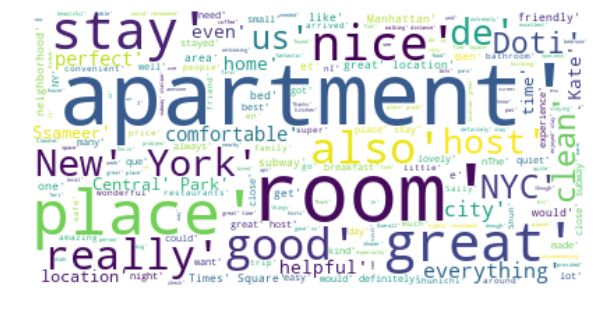

In [298]:
wordcloud_Returner(Man_cleaned)

--wordcloud run for 0.1654510498046875econds--


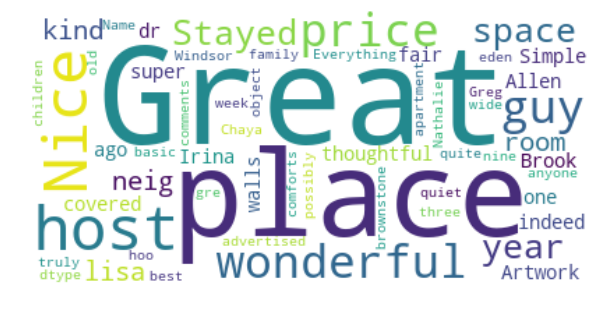

In [299]:
wordcloud_Returner(Bk)

## NLP

In [269]:
corpus=df.comments
corpus

0     Great host Nice room for the price. Great neig...
1     Notre séjour de trois nuits.\r\nNous avons app...
2     lisa is a wonderful, kind and thoughtful host....
3     Good location - easy access to Times Square an...
4     Great host with a very cute apartment. Easy an...
5     I had a great experience at Tina's "True NYC A...
6     Simple place, super nice guy.Great guy with a ...
7     MR. Kasai was a grreat host , very helpful and...
8     Emmie and her family are exceptional hosts. Th...
9     Ben was so hospitable and his apartment is ver...
10    Lena definitely has an awesome place in a prim...
11    I had an excellent experience with Kate. The p...
12    Artwork, indeed! The walls are covered with dr...
13    This was my first Airbnb experience and it cou...
14    Awesome!!As soon as we walked into the apartme...
15    Stayed with Allen and Irina about a year ago. ...
16    A great space for a fair price in one of Brook...
17    Chelsea Perfect - Room \r\nand so it is. T

In [270]:
type(corpus)

pandas.core.series.Series

In [273]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [274]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [307]:
clean_corpus=corpus.apply(lambda x :clean(x))

In [303]:
import pandas as pd
import numpy as np
import os
import requests, zipfile, io
import re
import string
import pickle
import time
import glob
from glob import iglob
from newspaper import Article
from datetime import datetime
import pickle
import csv
from langdetect import detect
from time import ctime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
import time
from PIL import Image

def wordcloud_Returner(text):
    start_time=time.time()
    text = str(text)
    stops = set(STOPWORDS)
    stops.add('None')

    text_wc = WordCloud(
    background_color='white',
    max_words=1000,
    stopwords=stops)
    text_wc.generate(text)

    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(15)
    plt.imshow(text_wc, interpolation='bilinear')
    plt.axis('off')
    print('--wordcloud run for % seconds--'% (time.time() - start_time))
    return fig

def bigrams_Returner(text):
    start_time=time.time()
    text = str(text)
    text = text.lower()
    text = text.split()
    stops = set(stopwords.words('english'))
    token =[]
    for i in text:
        if i in stops:
            continue
        else:
            token.append(i)
    bigrams = list(nltk.bigrams(token))
    print('--bigrams run for % seconds--'% (time.time() - start_time))
    return bigrams

def trigrams_Returner(text):
    start_time=time.time()
    text = str(text)
    text = text.lower()
    text = text.split()
    stops = set(stopwords.words('english'))
    token =[]
    for i in text:
        if i in stops:
            continue
        else:
            token.append(i)
    trigrams = list(nltk.trigrams(token))
    print('--trigrams run for % seconds--'% (time.time() - start_time))
    return trigrams

def wordcloud_mask_Returner(mask_name, text):
    start_time=time.time()
    mask = np.array(Image.open(mask_name))
    text = str(text)
    stops = set(STOPWORDS)

    text_wc = WordCloud(
    background_color='white',
    max_words=2000,
    mask=mask,
    stopwords=stops)
    text_wc.generate(text)

    fig = plt.figure()
    fig.set_figwidth(17)
    fig.set_figheight(25)
    plt.imshow(text_wc, interpolation='bilinear')
    plt.axis('off')
    fig.savefig(path_out+'wc_mask.png')
    print('--wordcloud_mask run for % seconds--'% (time.time() - start_time))
    return fig


In [305]:
trigrams_Returner(clean_corpus)

--trigrams run for 0.007398128509521484econds--


[('0', 'great', 'host'),
 ('great', 'host', 'nice'),
 ('host', 'nice', 'room'),
 ('nice', 'room', 'price'),
 ('room', 'price', '.'),
 ('price', '.', 'great'),
 ('.', 'great', 'neighborhoo...'),
 ('great', 'neighborhoo...', '1'),
 ('neighborhoo...', '1', 'notre'),
 ('1', 'notre', 'séjour'),
 ('notre', 'séjour', 'de'),
 ('séjour', 'de', 'trois'),
 ('de', 'trois', 'nuits'),
 ('trois', 'nuits', '.'),
 ('nuits', '.', 'nous'),
 ('.', 'nous', 'avons'),
 ('nous', 'avons', 'appré...'),
 ('avons', 'appré...', '2'),
 ('appré...', '2', 'lisa'),
 ('2', 'lisa', 'wonderful'),
 ('lisa', 'wonderful', ','),
 ('wonderful', ',', 'kind'),
 (',', 'kind', 'thoughtful'),
 ('kind', 'thoughtful', 'host'),
 ('thoughtful', 'host', '.'),
 ('host', '.', 'list'),
 ('.', 'list', '1...'),
 ('list', '1...', '3'),
 ('1...', '3', 'good'),
 ('3', 'good', 'location'),
 ('good', 'location', '-'),
 ('location', '-', 'easy'),
 ('-', 'easy', 'access'),
 ('easy', 'access', 'time'),
 ('access', 'time', 'square'),
 ('time', 'squa

In [306]:
bigrams_Returner(clean_corpus)

--bigrams run for 0.024363994598388672econds--


[('0', 'great'),
 ('great', 'host'),
 ('host', 'nice'),
 ('nice', 'room'),
 ('room', 'price'),
 ('price', '.'),
 ('.', 'great'),
 ('great', 'neighborhoo...'),
 ('neighborhoo...', '1'),
 ('1', 'notre'),
 ('notre', 'séjour'),
 ('séjour', 'de'),
 ('de', 'trois'),
 ('trois', 'nuits'),
 ('nuits', '.'),
 ('.', 'nous'),
 ('nous', 'avons'),
 ('avons', 'appré...'),
 ('appré...', '2'),
 ('2', 'lisa'),
 ('lisa', 'wonderful'),
 ('wonderful', ','),
 (',', 'kind'),
 ('kind', 'thoughtful'),
 ('thoughtful', 'host'),
 ('host', '.'),
 ('.', 'list'),
 ('list', '1...'),
 ('1...', '3'),
 ('3', 'good'),
 ('good', 'location'),
 ('location', '-'),
 ('-', 'easy'),
 ('easy', 'access'),
 ('access', 'time'),
 ('time', 'square'),
 ('square', 'subway...'),
 ('subway...', '4'),
 ('4', 'great'),
 ('great', 'host'),
 ('host', 'cute'),
 ('cute', 'apartment'),
 ('apartment', '.'),
 ('.', 'easy'),
 ('easy', 'quick'),
 ('quick', 'transit...'),
 ('transit...', '5'),
 ('5', 'great'),
 ('great', 'experience'),
 ('experience'

## Sentiment Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [2]:
listing_new = pd.read_csv('listings.csv')

In [3]:
reviews1 = pd.read_csv('reviews.csv')

In [7]:
rev = reviews1[reviews1['id'] < 1000000]

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for sentence in rev['comments'].values[:5]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

Notre séjour de trois nuits.
Nous avons apprécier L'appartement qui est très bien situé. Agréable, propre et bien soigné. C'est idéal pour une famille de 3 ou 4 personnes.
Petits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide.  A part ces petits détails notre court séjour c'est bien passé. 
Si j'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à "The Midtown Castle"
Jean
Possession - Ile de La Réunion

compound: -0.3612, neg: 0.021, neu: 0.979, pos: 0.0, 
Great experience.
compound: 0.6249, neg: 0.0, neu: 0.196, pos: 0.804, 
I've stayed with my friend at the Midtown Castle for six days and it was a lovely place to be. A big spacious room with a pointy roof, which really makes you feel like stayi

In [10]:
## filter out non-English reviews
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words

def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [11]:
reviews_filtered = [r for r in rev['comments'] if pd.notnull(r) and get_language(r) == 'english']

In [14]:
pscores = [sid.polarity_scores(comment) for comment in reviews_filtered]

## Neutrality

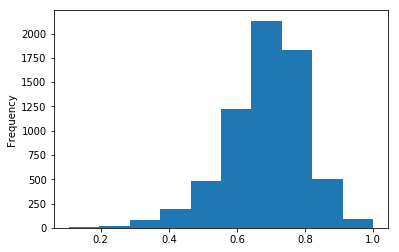

In [16]:
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')

## Positivity

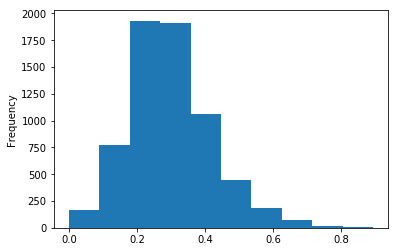

In [17]:
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')

## Negativity

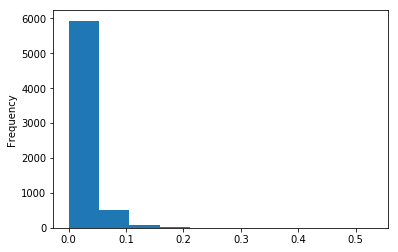

In [18]:
pd.Series([score['neg'] for score in pscores]).plot(kind='hist')
# almost none of the texts are classified as having significant negativity

In [19]:
scored_reviews = pd.DataFrame()
scored_reviews['review'] = [r for r in reviews_filtered if get_language(r) == 'english']
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [20]:
scored_reviews.head(5)

,review,compound,negativity,neutrality,positivity
0,I've stayed with my friend at the Midtown Cast...,0.9248,0.016,0.793,0.192
1,"We've been staying here for about 9 nights, en...",0.9229,0.000,0.808,0.192
2,We had a wonderful stay at Jennifer's charming...,0.9464,0.000,0.510,0.490
3,Good location - easy access to Times Square an...,0.9758,0.000,0.571,0.429
4,We had the best possible time in NYC and Russe...,0.9936,0.000,0.577,0.423


In [30]:
scored_reviews.query('negativity > positivity').query('negativity > 0.1')

,review,compound,negativity,neutrality,positivity
11,Dead cockroaches. Cat hair everywhere. Not ver...,-0.7766,0.530,0.470,0.000
20,You must be in shape to visit Tina apartmant. ...,-0.4402,0.114,0.813,0.073
23,Is glad to stay in Tina's Apt. the apt is just...,-0.2023,0.130,0.788,0.082
63,The apartment is not the place shown in the pi...,-0.7701,0.223,0.729,0.048
72,We stayed at Shun's place for a week in july. ...,-0.6767,0.104,0.826,0.071
221,Lena was so helpful and communicative througho...,0.2269,0.120,0.782,0.098
714,Ssameer is one righteous dude. If you don't ge...,-0.4767,0.162,0.838,0.000
819,A nice appartment but some bad details.\r\nif ...,-0.5259,0.131,0.772,0.097
884,Ssameer is a terrific host- gave us a key to g...,-0.4588,0.181,0.740,0.079
943,Great visit. It was our second time. No proble...,0.0757,0.248,0.544,0.209


## collocation

In [31]:
# extract common/significant phrases
reviews_df = rev[rev.apply(lambda srs: pd.notnull(srs['comments']) and (get_language(srs['comments']) == 'english'), axis='columns')]

In [32]:
reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
11,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
12,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
13,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...
311,4989,22938,2010-01-03,61471,Rachel,Good location - easy access to Times Square an...
312,4989,234213,2011-04-21,446902,Chris,We had the best possible time in NYC and Russe...
313,4989,264416,2011-05-15,540879,Kerry,Three of us stayed at this place for a week- i...
314,4989,843520,2012-01-06,1357796,Elise,A great apartment in the perfect location. I w...
315,4989,993034,2012-03-12,1757830,Ferris,Russ is an amazing host and his awesome apartm...
347,5099,1683,2009-04-20,13301,Melissa,"I had a great experience at Tina's ""True NYC A..."
348,5099,4107,2009-06-16,13219,Kasper,My girlfriend and me had a wonderful time at T...


In [36]:
example_listing_reviews = reviews_df.query('listing_id == 5099')

In [34]:
len(example_listing_reviews)

21

In [37]:
from nltk import word_tokenize

In [38]:
words = np.concatenate(np.array([word_tokenize(r) for r in example_listing_reviews['comments'].values]))

In [39]:
words

array(['I', 'had', 'a', ..., 'with', 'her', '!'], dtype='<U15')

In [40]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)

finder.apply_freq_filter(3) 
finder.nbest(bigram_measures.pmi, 10) 

[('Central', 'Station'),
 ('Grand', 'Central'),
 ('walk', 'from'),
 ('go', 'back'),
 ('definitely', 'recommend'),
 ('did', "n't"),
 ('at', 'home'),
 ('Thank', 'you'),
 ('we', 'got'),
 ('I', 'would')]

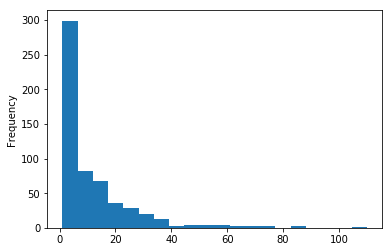

In [41]:
reviews_df.groupby('listing_id')['comments'].count().plot(kind='hist', bins=20)

In [42]:
review_words = reviews_df.groupby('listing_id').apply(
    lambda df: np.concatenate(np.array([word_tokenize(r) for r in df['comments'].values]))
)

In [47]:
review_words

listing_id
2595      [I, 've, stayed, with, my, friend, at, the, Mi...
4989      [Good, location, -, easy, access, to, Times, S...
5099      [I, had, a, great, experience, at, Tina, 's, `...
5121      [Great, guy, with, a, basic, room, ., Clean, s...
5178      [MR., Kasai, was, a, grreat, host, ,, very, he...
5203      [Emmie, and, her, family, are, exceptional, ho...
5238      [Ben, was, so, hospitable, and, his, apartment...
5295      [Lena, definitely, has, an, awesome, place, in...
5441      [I, had, an, excellent, experience, with, Kate...
5803      [Artwork, ,, indeed, !, The, walls, are, cover...
6021      [This, was, my, first, Airbnb, experience, and...
6090      [As, soon, as, we, walked, into, the, apartmen...
6848      [Stayed, with, Allen, and, Irina, about, a, ye...
7097      [A, great, space, for, a, fair, price, in, one...
7322      [Chelsea, Perfect, -, Room, and, so, it, is, ....
7801      [We, stayed, at, Chaya, 's, place, for, a, wee...
8024      [This, was, quite, 

In [44]:
import string

In [45]:
review_words_f = review_words.map(lambda arr: np.array([w for w in arr if w not in string.punctuation]))

In [46]:
review_words_f.head()

listing_id
2595    [I, 've, stayed, with, my, friend, at, the, Mi...
4989    [Good, location, easy, access, to, Times, Squa...
5099    [I, had, a, great, experience, at, Tina, 's, `...
5121    [Great, guy, with, a, basic, room, Clean, shee...
5178    [MR., Kasai, was, a, grreat, host, very, helpf...
dtype: object

In [49]:
def reattach_contractions(wordlist):
    words = []
    for i, word in enumerate(wordlist):
        if word[0] == "'" or word == "n't":
            words[-1] = words[-1] + word
        else:
            words.append(word)
    return words

In [50]:
review_words_f = review_words_f.map(reattach_contractions)

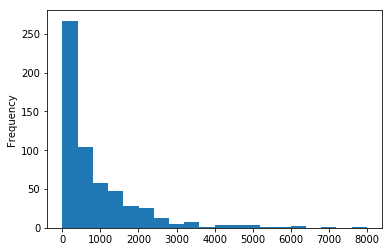

In [51]:
review_words_f.map(len).plot(kind='hist', bins=20)

In [52]:
def bigramify(words):
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(3) 
    return finder.nbest(bigram_measures.pmi, 3)

review_bigrams = review_words_f.map(bigramify)

In [53]:
review_bigrams.head(20)

listing_id
2595                                                   []
4989                                           [(was, a)]
5099    [(Grand, Central), (Central, Station), (walk, ...
5121                [(laid, back), (at, home), (lot, of)]
5178               [(’, s), (save, money), (block, away)]
5203    [(as, advertised), (exactly, as), (always, rea...
5238    [(Highly, recommended), (New, York), (an, awes...
5295        [(very, comfortable), (our, stay), (to, eat)]
5441    [(Hell's, Kitchen), (Central, Park), (New, York)]
5803    [(walking, distance), (Park, Slope), (getting,...
6021        [(Website, hidden), (airb, b), (upper, west)]
6090              [(New, York), (very, clean), (We, had)]
6848    [(customer, service), (have, been), (couldn't,...
7097         [(Fort, Greene), (have, been), (top, floor)]
7322    [(Website, hidden), (walking, distance), (old,...
7801             [(at, home), (It, was), (Chaya's, loft)]
8024    [(Park, Slope), (highly, recommend), (full, ki...
811

In [54]:
def sample_reviews(listing_id):
    bigrams = review_bigrams[listing_id]
    review_texts = reviews[reviews['listing_id'] == listing_id]['comments'].values
    sample_reviews = []
    for bigram in bigrams:
        sample_review_list = list(filter(lambda txt: " ".join(bigram) in txt, review_texts))
        num_reviews = len(sample_review_list)
        sample_review = sample_review_list[0]
        sample_review = sample_review.replace(" ".join(bigram), "****" + " ".join(bigram) + "****")
        start_index = sample_review.index("****")
        sample_text = "..." + sample_review[start_index - 47: start_index + 47] + "..."
        sample_reviews.append(sample_text)
    return sample_reviews

In [55]:
sample_reviews

<function __main__.sample_reviews(listing_id)>